In [3]:
!git clone https://github.com/prlabu/Speech-Articulatory-Coding.git

fatal: destination path 'Speech-Articulatory-Coding' already exists and is not an empty directory.


In [4]:
!pip install -e /content/Speech-Articulatory-Coding/.

Obtaining file:///content/Speech-Articulatory-Coding
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux201

In [5]:
import sys
import os
import glob
# sys.path.append("/content/Speech-Articulatory-Coding/")
sys.path.insert(0,"/content/Speech-Articulatory-Coding/")


In [6]:
%load_ext autoreload
%autoreload 2
import importlib
# import sparc
from sparc import load_model
import copy
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime

In [7]:
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

In [8]:
coder = load_model("en", device= "cpu", use_penn=True)

load_model v3


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_english_1500k.yaml:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model_english_1500k.ckpt:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

load_model v3


config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Using PENN for pitch tracking.


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [9]:
# import sys
# # import scipy as sp
# import sklearn as skl
# from sklearn.decomposition import PCA
# import pandas as pd


import numpy as np

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualize EMA trajectories from wav

In [ ]:
color_code = {"UL":mpl.colors.to_rgb("#EE3A5B"),
              "LL":mpl.colors.to_rgb("#FFD155"),
              "LI":mpl.colors.to_rgb("#959595"),
              "TT":mpl.colors.to_rgb("#43B962"),
              "TB":mpl.colors.to_rgb("#C44B9F"),
              "TD":mpl.colors.to_rgb("#0093B7"),
              "Loudness":mpl.colors.to_rgb("#FB754D"),
              "Pitch":mpl.colors.to_rgb("#FB754D"),}

HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2, plot_velocity=False):
    yticks=[]
    ytick_labels=[]
    labels = ["UL","LL", "LI", "TT", "TB", "TD"]
    chidxs = []
    HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    channel_label = HPRC_channel_label
    for l in labels:
        chidxs.append(HPRC_channel_label.index(l+"X"))
        chidxs.append(HPRC_channel_label.index(l+"Y"))

    time = np.arange(0, art.shape[0]) / 50
    # print(len(art))
    # print(time)
    for i, ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
        else:
            art_name = ch_label
            if color is None:
                color = color_code[art_name]
        x = art[:,ch_i]
        ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw)
        if plot_velocity:
            ax.plot(time, 2*np.concatenate(([0], np.diff(x))) - gap*i,color='r',alpha=alpha*0.5,lw=1)

        yticks.append(-gap*i)

    i = i+1
    # diffs = np.diff(art, axis=0)
    # maxdiffs = np.max(diffs, axis = 1)
    diffs = np.vstack([np.zeros((1, 12)), np.abs(np.diff(art, axis=0))])
    maxdiffs = np.max(diffs, axis = 1)
    ax.plot(time, 2*maxdiffs-gap*i,color='r',alpha=alpha*0.5,lw=lw)
    yticks.append(-gap*i)
    ytick_labels.append('~max velocity')

    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    # xticks= np.arange(0,len(art),50)
    # xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    # ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    # ax.set_xlim(0,len(art))
    return yticks

In [20]:
yticks=[]
ytick_labels=[]
labels = ["UL","LL", "LI", "TT", "TB", "TD"]
chidxs = []


['TDX',
 'TDY',
 'TBX',
 'TBY',
 'TTX',
 'TTY',
 'LIX',
 'LIY',
 'ULX',
 'ULY',
 'LLX',
 'LLY']

In [ ]:
# wav_file  = '../sample_audio/pataka-fast.wav'
wav_file  = '../sample_audio/be2d.wav'
wav_file2  = '../sample_audio/be2d-fran-trim-2.wav'
wav_file3  = '../sample_audio/be2d-chin-trim.wav'

# wav_file  = '/Volumes/Nexus4/DBS/derivatives/sub-DM1033/aec/sub-DM1033_ses-intraop_task-lombard_run-03_recording-directionalmicaec_physio.wav'
# wav_file = '../sample_audio/sub-DM1033_ses-intraop_task-lombard_run-03_directionalmicaec-start-99s.wav'

codes = [coder.encode(f) for f in [wav_file, wav_file2, wav_file3]]
# code = coder.encode(wav_file)
# code2 = coder.encode(wav_file2)

# sound = out['wav']
# ema = out['ema'].squeeze()


        # x = art[:,ch_i]
        # ax.plot(time, np.concatenate(0, np.diff(x))-gap*i,color='r',alpha=alpha*0.5,lw=1)
        # ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw)
# i = i+1
# diffs = np.vstack([np.zeros((1, 12)), np.diff(ema, axis=0)])
# maxdiffs = np.max(ema, axis = 1)
# ax.plot(time[2:-1], maxdiffs-gap*i,color=color,alpha=alpha,lw=lw)
# maxdiffs.shape
# maxdiffs.shape

wav, wav_fs = sf.read(wav_file)
# # wav.size


# {k:v.shape for k, v in codes[1].items()}
# {k:v.shape for k, v in code.items()}


In [ ]:
allacoustics = np.concatenate([c['acoustics_wvlm'] for c in codes], axis=0)
pca = PCA().fit(allacoustics)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

allacoustics_stats = pd.DataFrame({'min': np.amin(allacoustics, axis=0).T,
                                   'max': np.amax(allacoustics, axis=0).T})

In [ ]:
codes[1]['loudness'].shape

In [ ]:
acoustics_wvlm_tranformed = [pca.transform(c['acoustics_wvlm'])[:, 0:12] for c in codes]
for i, c in enumerate(codes):
    c.update({'acoustics_wvlm_transform': acoustics_wvlm_tranformed[i]})
#     c['acoustics_wvlm'] =
# acoustics_wvlm_tranformed[1].shape
# codes[1].keys()

In [ ]:
offset = -100
# c = codes[2]
for c in codes:
    d = c['acoustics_wvlm_transform']
    plt.gca().set_prop_cycle(None)
    for i in range(d.shape[1]):
        plt.plot(d[:, i] + i*offset)

plt.gca().set_yticks([])
plt.gca().set_ylabel('wavLM 1024-to-PCA dimensions')
plt.gca().set_xlabel('Time [sample]')

In [ ]:
fig,ax = plt.subplots(3,1, figsize=(5,10), sharex=True)

ax[0].plot(np.arange(0, wav.size) / wav_fs, wav)

for code in codes:
    plot_art(ax[1], (code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], perturb_ema(code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], (code2['ema']), color='C0', gap=6, alpha=0.5, lw=1)


plt.show()

# Simple encode-decode resynthesis

In [ ]:

(fdir, fname) = os.path.split(files[0])
(fname, fext) = fname.split('.')

code_orig = coder.encode(files[0])
# code_orig.pop('wav', None)
code_orig.keys()

# Load DIVA babbling files

In [ ]:
# encode and resynthesize a whole series of files
# for f in

FS_SPARC_CODE = 50
SPARC_EMA_LABELS = ["ULX", "ULY", "LLX", "LLY",  "LIX", "LIY",  "TTX", "TTY", "TBX", "TBY", "TDX", "TDY"]


In [ ]:

# files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
files = [f for f in files if '20250226' in f ]

for idx_f, f in enumerate(files):
# f = files[0]
    print(idx_f, f)
    # if idx_f<500: % 500 files were run 20250225
    #   continue

    (fdir, fname) = os.path.split(f)
    (fname, fext) = fname.split('.')
    if os.path.exists(dir_out + fname + '-resynth-ema.csv'):
        continue

    code_orig = coder.encode(f)
    code_orig.pop('wav', None)


    # write EMA
    code = code_orig['ema'].squeeze()
    code_time = np.arange(1, code.shape[0]+1)  / FS_SPARC_CODE

    df = pd.DataFrame(code)
    df.columns = SPARC_EMA_LABELS
    df['file_id'] = fname
    df['time'] = code_time
    df.to_csv(dir_out + fname + '-resynth-ema.csv', index=False)

    # write wavLM features
    code = code_orig['acoustics_wvlm'].squeeze()
    code_time = np.arange(1, code.shape[0]+1)  / FS_SPARC_CODE
    nfeat = code.shape[1]

    df = pd.DataFrame(code)
    df.columns = ["wavlm_"+str(i) for i in range(0, nfeat)]
    df['file_id'] = fname
    df['time'] = code_time
    df.to_csv(dir_out + fname + '-resynth-wavlm.csv', index=False)

    # write wav file
    wav = coder.decode(**code_orig)
    sf.write(dir_out + fname + '-resynth.wav', wav, coder.sr)

    # write full pickle file
    with open(dir_out + fname + '-resynth.pickle', 'wb') as handle:
            pickle.dump(code_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Learn the matrix W from prior samples

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler


files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
# files = [f for f in files if '202502' in f ]
print(f'n files: {len(files)}')

data_all = []
# Create an SGD-based OLS model
# model = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.0001, verbose=1, warm_start=True)
# model = LinearRegression()
# model = MultiOutputRegressor(model, n_jobs=-1)

# score = np.zeros([13, 1])
# score[:] = np.nan
score = []
ibatch = 0

for idx_f, f in enumerate(files):

  # if not (idx_f>=0 and idx_f<=251):
  #   continue
  # f = files[0]
  print(idx_f, f)

  (fdir, fname) = os.path.split(f)
  (fname, fext) = fname.split('.')

  diva = pd.read_csv(fdir + "/" + fname + '.csv')

  fname_wavlm = dir_out + fname + '-resynth-wavlm.csv'
  if not os.path.exists(fname_wavlm):
      continue
  wavlm = pd.read_csv(fname_wavlm)

  diva_interp = pd.DataFrame({'time': wavlm['time']})  # Keep B's time vector


  id_cols = ['time', 'file_id']
  for col in diva.columns:
      if col in id_cols:  # Skip 'time' column
          continue
      diva_interp[col] = np.interp(wavlm['time'], diva['time'], diva[col])

  # Merge interpolated A with B
  df_merged = pd.merge(wavlm, diva_interp, how='inner', on='time')
  cols = id_cols + [col for col in df_merged.columns if col not in id_cols]
  df_merged = df_merged[cols]

  data_all.append(df_merged)

  # RUN LEAST SQUARES OR SGD-OLS
  if np.mod(len(data_all), 30)==0:
    print(f'Batch update: {ibatch}')
    df_data_all = pd.concat(data_all, ignore_index=True, axis=0)

    cols_wavlm  = [col for col in df_data_all.columns if 'wavlm' in col]
    cols_diva = [col for col in df_data_all.columns if col not in cols_wavlm+id_cols]

    X = df_data_all[cols_wavlm]
    Y = df_data_all[[col for col in cols_diva if col not in ["Tension", "Pressure", "Voicing"]]]

    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Scale features
    # X = scaler_X.fit_transform(X)
    # Y = scaler_Y.fit_transform(Y)

    if ibatch==0:
      print('Batch 0: fitting with OLS then SGD')

      ols = LinearRegression()
      ols.fit(X, Y)
      # Initialize SGD
      base_sgd = SGDRegressor(max_iter=1000, tol=1e-3, warm_start=True, eta0=0.0001)
      model = MultiOutputRegressor(base_sgd, n_jobs=-1)

      # model = LinearRegression()
      model.fit(X, Y)

      # # Initialize SGD with warm_start=True
      # # Manually set coef_ and intercept_ for each output target
      # for i, est in enumerate(model.estimators_ if hasattr(model, 'estimators_') else []):
      #     est.coef_ = ols.coef_[i]  # Set the coefficient vector
      #     est.intercept_ = ols.intercept_[i]  # Set the intercept

      # model.fit(X, Y, coef_init=ols.coef_.copy(), intercept_init=ols.intercept_.copy())
      # model.fit(X, Y)

    else:
      print('Batch >0: fitting with SGD')
      model.partial_fit(X, Y) # if ibatch>=1 else
      # model.fit(X, Y) # Train incrementally
      # model.coef_ = (model.coef_ + model_last.coef_) / 2
      # model.intercept_ = (model.intercept_ + model_last.intercept_) / 2

    # model.fit(X, Y)  # Train incrementally
    # score[0, ibatch] = model.score(X, Y)

    Y_pred = model.predict(X)

    resSS = ((Y - Y_pred)** 2).sum(axis=0)
    ySS = ((Y - Y.mean(axis=0)) ** 2).sum(axis=0)
    r2 = 1 - np.divide(resSS, ySS)
    r2['ns'] = X.shape[0]

    score.append(r2)
    # score = pd.concat([score, r2], ignore_index=True, axis=0)

    del data_all
    data_all = []
    ibatch += 1
    model_last = model

  # out = np.linalg.lstsq(df_merged[cols_wavlm], df_data_all[cols_diva])


  # # verify that interpolation is correct d
  # fig, ax = plt.subplots(2, 1)
  # ax[0].plot(df_merged['time'], df_merged['Jaw'])
  # ax[0].plot(df_merged['time'], df_merged['Jaw']+0.05, alpha=0.5)

# df_data_all = pd.concat(data_all, ignore_index=True, axis=0)



In [ ]:
score = pd.DataFrame(score)
score

In [ ]:
plt.plot(score[[c for c in score.columns if c not in ['ns']]])

In [ ]:
df_merged

In [ ]:
# save data to disk
# df_data_all['file_id'].nunique()
# df_data_all.to_csv(dir_out + 'df_data_all_wavlm-and-divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)



In [ ]:
# cols_wavlm  = [col for col in df_data_all.columns if 'wavlm' in col]
# cols_diva = [col for col in df_data_all.columns if col not in cols_wavlm+id_cols]
# out = np.linalg.lstsq(df_data_all[cols_wavlm], df_data_all[cols_diva])

# when using MultiOutput + SGD
W = [m.coef_ for m in model.estimators_]
W = np.vstack(W)

b = [m.intercept_ for m in model.estimators_]
b = np.concat(b)
b = pd.DataFrame({'b': b})

# # when using MultiOutput + SGD
# W = model.coef_
# b = pd.DataFrame({'b': model.intercept_})

# save values to disk
pd.DataFrame.from_records(W).to_csv(dir_out + 'W_wavlm2divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)
pd.DataFrame.from_records(b).to_csv(dir_out + 'Wb_wavlm2divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)

In [ ]:
W = [m.coef_ for m in model.estimators_]
W = np.vstack(W).shape

b = [m.intercept_ for m in model.estimators_]
b = np.concat(b)
b = pd.DataFrame({'b': b})



# Visualize trajectories of Y_pred

In [ ]:
df_data_all

In [ ]:
W = pd.read_csv(f'{topdir}/sample_audio/diva_babbling_resynth/W_wavlm2divaart-202502261732.csv')
b = pd.read_csv(f'{topdir}/sample_audio/diva_babbling_resynth/Wb_wavlm2divaart-202502261732.csv')
W = W.iloc[:, 1:].values
b = b.iloc[:, 1].values
# # alternatively, W and b from model if it was run
# W = model.coef_
# b = model.intercept_

# print(df_data_all[cols_wavlm].shape)
# print(W.T.shape)
# Y_pred = df_data_all[cols_wavlm] @ W.T + b

# alternatively
# Y_pred = model.predict(X)
print(W.shape)
print(b.shape)


In [ ]:

df_pred = pd.DataFrame.from_records(Y_pred)
df_pred.columns = [s+"_pred" for s in cols_diva]
df_data_all = pd.concat([df_data_all, df_pred], axis=1)

In [ ]:
df_data_all

In [ ]:
# calculate sum of squares prediction value for each articulator
r2 = {}
for i, col in enumerate(cols_diva):
    # col = "Jaw"
    # corr = np.dot(df_data_all[col], df_data_all[col+"_pred"])
    res = df_data_all[col+"_pred"] - df_data_all[col]
    r2[col] = 1 - ((res**2).sum()) / (df_data_all[col]**2).sum()
    r2[col] = float(np.round(r2[col], 2))
# np.corrcoef(df_data_all[col+"_pred"], df_data_all[col])
r2

In [ ]:
fileex = 'diva_babbling-20250224123835338'
df_plot = df_data_all[df_data_all['file_id']==fileex]

fig, ax = plt.subplots(figsize=[12, 10])
cm = np.asarray(mpl.colormaps['tab10'].colors)
offset = 1.5
for iart,art_name in enumerate(cols_diva):
    cur_offset = iart*offset
    ax.plot(df_plot['time'], cur_offset + df_plot[art_name],         color=cm[iart % cm.shape[0], :], alpha=0.5)
    ax.plot(df_plot['time'], cur_offset + df_plot[art_name+"_pred"], color=cm[iart % cm.shape[0], :], linestyle='--')

ax.set_yticks(offset*np.arange(len(cols_diva)), [c + " (r2=" + str(round(r2[c], 2)) + ")" for c in cols_diva] )
plt.show()

# Convert test wav file to diva art time series using learned W

In [ ]:
wav_file = f'{topdir}/sample_audio/eeayeeayoo.wav'
# wav_file = '../sample_audio/thisisme-lat.wav'

(fdir, fname) = os.path.split(wav_file)
(fname, fext) = fname.split('.')

In [ ]:

code_orig = coder.encode(wav_file)


In [ ]:
# code_orig
wavlm  = code_orig['acoustics_wvlm']
divaart_predic = wavlm @ W.T + b
pd.DataFrame.from_records(divaart_predic).to_csv(fdir + "/" +  fname + '-divaart-predic-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=False)

# Encode, resynthesize, perturb wav file

In [ ]:
vars_timeseries = ['ema', 'loudness', 'pitch', 'periodicity']
# wav_file = '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav'
code_orig = coder.encode(wav_file)
# code_orig = {k : v.squeeze().shape for k, v in code_orig.items() if k in ['ema', 'loudness', 'pitch', 'periodicity']}
# code_orig =

code_orig = {k: (v.squeeze(axis=0) if k in vars_timeseries+["spk_emb"] and v.shape[0]==1 else v) for k, v in code_orig.items()}
# {k : (v.shape if k in ['ema', 'loudness', 'pitch', 'periodicity', 'acoustics_wvlm', 'spk_emb'] else v) for k,v in code_orig.items()}


### Plot the SPARC linear transform from auditory to motor space

In [ ]:
W = coder.inverter.linear_model.weight.float().numpy()
B = coder.inverter.linear_model.bias.float().numpy()
fig, ax = plt.subplots(figsize=[20, 10])
ax.imshow(W[:, 100:200])
W.shape

In [ ]:
wav = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth.wav', wav, coder.sr)

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
def perturb_ema(ema):
    pert = np.zeros_like(ema)
    pert_t = np.arange(0, pert.shape[0]) / 50

    t_pert_start = 0.3
    t_pert_end = 1.2

    idxs_x = [s in ['TBX', 'TDX'] for i,s in enumerate(HPRC_channel_label)]
    idxs_y = [s in ['TBY', 'TDY'] for i,s in enumerate(HPRC_channel_label)]

    idxs_t = (pert_t>t_pert_start) & (pert_t<t_pert_end)

    # pert[idxs_t, idxs_x] = 0.1
    pert[np.ix_(idxs_t, idxs_x)] = 0.5
    pert[np.ix_(idxs_t, idxs_y)] = 1

    # pert = [ for i in range(pert.shape[1])]
    pert = np.apply_along_axis(lambda x : sp.signal.savgol_filter(x, 5, 2), axis=0, arr=pert)

    # plt.imshow(pert)
    # np.max(ema, axis=0)
    return ema + pert

In [ ]:
code = copy.deepcopy(code_orig)
# code = code_orig.copy()

code['ema'] = perturb_ema(code_orig['ema'])
wav = coder.decode(**code)
sf.write(wav_file[0:-4] + '-resynth-pert.wav', wav, coder.sr)

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# extend the perturbation
code = copy.deepcopy(code_orig)

idx_split = 44
def extendmat(m, idx_split, nrpt, axis=0):
    return np.concatenate((m[0:idx_split, :], np.tile(m[idx_split, :], (nrpt, 1)), m[idx_split:-1, :]), axis=axis)

code =  {k: (extendmat(v, idx_split, 100) if k in ['ema', 'loudness', 'pitch', 'periodicity'] else v) for k, v in code.items()}
# {k: extendmat(v, idx_split, 20) for k, v in code.items()}
# {k: (v.shape if k in vars_timeseries else 1) for k, v in code.items()}

wav = coder.decode(**code)
sf.write(wav_file[0:-4] + '-resynth-extended.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# test the minimal amount of data we can pass to the synthesizer
code = copy.deepcopy(code_orig)

idx_width = 1
idx_center = 40
def slicemat(m, idx_width, idx_center):
    idxs = np.arange(idx_width) + idx_center
    return m[idxs, :]

code =  {k: (slicemat(v, idx_width, idx_center) if k in ['ema', 'loudness', 'pitch', 'periodicity'] else v) for k, v in code.items()}
# {k: extendmat(v, idx_split, 20) for k, v in code.items()}
# {k: (v.shape if k in vars_timeseries else 1) for k, v in code.items()}


In [ ]:

wav = coder.decode(**code)
print(f'Duration: {len(wav) / coder.sr}')
sf.write(wav_file[0:-4] + '-sliced.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

# Detect audio errors from bed to bad, apply to motor command

In [ ]:
vars_timeseries = ['ema', 'loudness', 'pitch', 'periodicity']

wav_file_bed  = '../sample_audio/bed-lat.wav'
wav_file_bAd  = '../sample_audio/bad-lat.wav'

# trim wav files to make them equal length
wav_bed,wav_bed_sr = sf.read(wav_file_bed)
wav_bAd,wav_bAd_sr = sf.read(wav_file_bAd)

if len(wav_bed)>len(wav_bAd):
    wav_bed = wav_bed[0:len(wav_bAd)]
else:
    wav_bAd = wav_bAd[0:len(wav_bed)]

print(len(wav_bed), len(wav_bAd))
sf.write(wav_file_bed[0:-4] + '-trim.wav', wav_bed, wav_bed_sr)
sf.write(wav_file_bAd[0:-4] + '-trim.wav', wav_bAd, wav_bed_sr)


In [ ]:
wav_file_bed  = '../sample_audio/bed-lat-trim.wav'
wav_file_bAd  = '../sample_audio/bad-lat-trim.wav'

def squeeze_code(code_orig):
    return {k: (v.squeeze(axis=0) if k in vars_timeseries+["spk_emb"] and v.shape[0]==1 else v) for k, v in code_orig.items()}

codes = [coder.encode(f) for f in [wav_file_bed, wav_file_bAd]]
codes = [squeeze_code(c) for c in codes]


In [ ]:
# get error traces
W = coder.inverter.linear_model.weight.float().numpy()
B = coder.inverter.linear_model.bias.float().numpy()

A_error = codes[1]['acoustics_wvlm'] - codes[0]['acoustics_wvlm']
M_error = np.dot(A_error, W.T) + B
M_error = M_error


In [ ]:
code_new = copy.deepcopy(codes[0])
code_new['ema'] = codes[0]['ema'] + M_error

codes.append(code_new)

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(5,10), sharex=True)

ax[0].plot(np.arange(0, wav_bed.size) / sr, wav_bed)

for code, color in zip(codes, ['tab:red', 'tab:blue','tab:purple']):
    print(color)
    plot_art(ax[1], (code['ema']), color=color, gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], perturb_ema(code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], (code2['ema']), color='C0', gap=6, alpha=0.5, lw=1)


plt.show()

In [ ]:
wavs_resynth = [coder.decode(**c) for c in codes]

sf.write(wav_file_bed[0:-4] + '-resynth.wav', wavs_resynth[0], coder.sr)
sf.write(wav_file_bAd[0:-4] + '-resynth.wav', wavs_resynth[1], coder.sr)
sf.write(wav_file_bed[0:-4] + '-pert-towards-bad-resynth.wav', wavs_resynth[2], coder.sr)


In [ ]:
# listen to all three:
ipd.display(ipd.Audio(wavs_resynth[0], rate=coder.sr))
ipd.display(ipd.Audio(wavs_resynth[1], rate=coder.sr))
ipd.display(ipd.Audio(wavs_resynth[2], rate=coder.sr))




# Use PC decomposition to perturb motor trajectories

In [27]:
# files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
# topdir = '/projectnb/busplab/lbullock/sparc_sample_audio' # for BU SCC
topdir = '/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding'
# files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
files = glob.glob(f'{topdir}/sample_audio/eeayeeayoo.wav')

# dir_out = '../sample_audio/diva_babbling_resynth_20250224/'
# dir_out = '/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/sample_audio/diva_babbling_resynth_20250224/'
dir_out = (f'{topdir}/sample_audio/diva_babbling_resynth/')

files[0:10]


['/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/sample_audio/eeayeeayoo.wav']

In [90]:
hprc_channels = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
mngu_channels = [
    'T3_x', 'T3_y',   # TD → T3
    'T2_x', 'T2_y',   # TB → T2
    'T1_x', 'T1_y',   # TT → T1
    'JAW_x','JAW_y',  # LI → JAW
    'UL_x', 'UL_y',   # UL → UL
    'LL_x', 'LL_y'    # LL → LL
]
hprc2mngu = {
    'LIX': 'JAW_x',
    'LIY': 'JAW_y',
    'ULX': 'UL_x',
    'ULY': 'UL_y',
    'LLX': 'LL_x',
    'LLY': 'LL_y',
    'TTX': 'T1_x',
    'TTY': 'T1_y',
    'TBX': 'T2_x',
    'TBY': 'T2_y',
    'TDX': 'T3_x',
    'TDY': 'T3_y',
}
mngu2hprc = {v: k for k, v in hprc2mngu.items()}
idxs_hprc2mngu = [hprc_channels.index(mngu2hprc[c]) for c in mngu_channels]
idxs_mngu2hprc = [mngu_channels.index(hprc2mngu[c]) for c in hprc_channels]
# [hprc[i] for i in idxs_hprc2mngu]



# # hprc index to mngu index
# idxs_hprc2mngu = [
#     6, 7,   # LIX, LIY → JAW_x, JAW_y
#     8, 9,   # ULX, ULY → UL_x, UL_y
#     10, 11, # LLX, LLY → LL_x, LL_y
#     4, 5,   # TDX, TDY → T1_x, T1_y
#     2, 3,   # TBX, TBY → T2_x, T2_y
#     0, 1    #  TTX, TTY → T3_x, T3_y
# ]

# # mngu index to hprc index
# idxs_mngu2hprc = [
#     6, 7,   # T3_x, T3_y → TTX, TTY
#     8, 9,   # T2_x, T2_y → TBX, TBY
#     10,11,  # T1_x, T1_y → TDX, TDY
#     0, 1,   # JAW_x, JAW_y → LIX, LIY
#     2, 3,   # UL_x, UL_y → ULX, ULY
#     4, 5    # LL_x, LL_y → LLX, LLY
# ]

# # Check forward mapping
# # assert all([hprc[i] == mngu[j].replace("_", "").upper() for i, j in enumerate(idxs_hprc2mngu)])

# # Check reverse mapping
# # assert all([mngu[i] == hprc[j].lower().replace("x", "_x").replace("y", "_y") for i, j in enumerate(idxs_mngu2hprc)])
# [hprc[i] for i in idxs_hprc2mngu]



[6, 7, 8, 9, 10, 11, 4, 5, 2, 3, 0, 1]

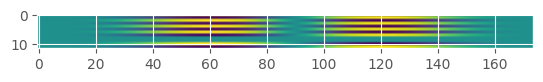

In [107]:
idxs_tongue = np.array([1, 2, 3, 4, 5, 6]) - 1
idxs_jaw = np.array([7, 8]) - 1
idxs_lips = np.array([9, 10, 11, 12]) - 1
idxs_UL = np.array([9, 10]) - 1
PC = pd.read_csv(f'{topdir}/../mngu0_ema/PC-12d.csv')


def m2M(m, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL
  mask_jawUL = np.ones_like(m)
  mask_jawUL[[7,8,9,10]] = 0

  m_jawtile = np.tile(m(idxs_jaw), 6)

  m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  M = np.dot(np.linalg.inv(PC), m_jawrel)
  return M


def M2m(M, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL

  mask_jawUL = np.ones_like(M)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL])] = 0

  m = np.dot(PC, M)

  m = m + np.multiply(mask_jawUL, np.tile(m[idxs_jaw], [6, 1]))

  return m

# M = np.array([0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0])
# M = np.zeros_li?e(ema, )

ema = np.squeeze(code_orig['ema'])
ema_pert_M = np.zeros_like(ema)
ema_pert_M[[60], idxs_jaw[0]] = 0.5
ema_pert_M[[120], idxs_jaw[0]] = -0.5

ema_pert_M.shape

ema_pert_M[:, idxs_jaw[0]] = np.convolve(np.hanning(100), ema_pert_M[:, idxs_jaw[0]], 'same')

# M[idxs_jaw[0]] = 0.5

# M2m(M, PC)


plt.imshow(ema_pert_M.T)
plt.imshow(M2m(ema_pert_M.T, PC))







(1, 174, 12)

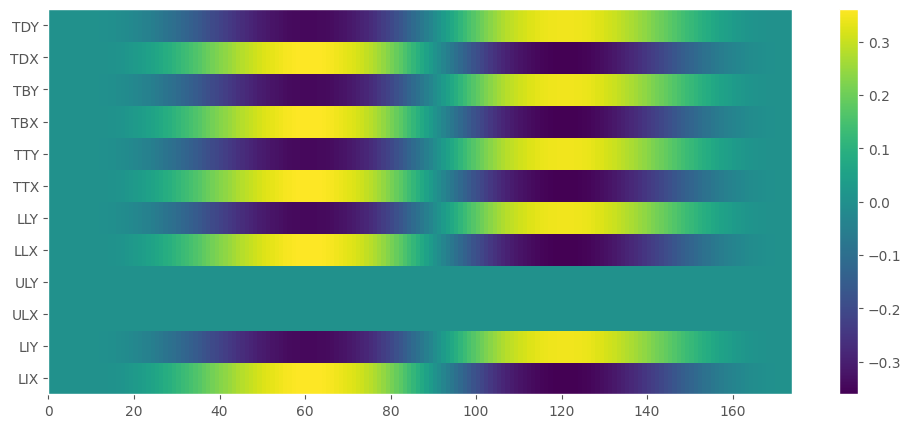

In [110]:
ema_pert_mngu = M2m(ema_pert_M.T, PC).T
ema_pert_hprc = ema_pert_mngu[:, idxs_mngu2hprc]

fig, ax = plt.subplots(figsize=[12, 5])
im = ax.pcolor(ema_pert_hprc.T)
ax.set_yticks(np.arange(0.5, len(hprc_channels), 1), (hprc_channels))
fig.colorbar(im, ax=ax)

np.expand_dims(ema_pert_hprc, axis=0).shape


In [109]:
# TESTING
wav_file = files[0]

code_orig = coder.encode(wav_file)
print(code_orig['acoustics_wvlm'].shape)
print(code_orig['ema'].shape)

wav = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth.wav', wav, coder.sr)


code_orig['ema'] = np.expand_dims(ema_pert_hprc, axis=0)
wav_pert = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth-pert.wav', wav_pert, coder.sr)

# ground truth
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

# resynthesized--pert
ipd.display(ipd.Audio(wav_pert, rate=coder.sr))


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4
(174, 1024)
(1, 174, 12)


# Voice Conversion

In [ ]:
# src_wav_file = '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav' # '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav'
# src_wav_file = '../sample_audio/sub-DM1033_ses-intraop_task-lombard_run-03_directionalmicaec-start-99s.wav'
src_wav_file = '../sample_audio/thisisme-lat.wav'

# targspkemb_wav_file = '../sample_audio/be2d-chin-trim.wav'
targspkemb_wav_file = '../sample_audio/thisisme-fran.wav'


In [ ]:
converted_wav = coder.convert(src_wav_file, targspkemb_wav_file)
ipd.display(ipd.Audio(converted_wav, rate=coder.sr))

sf.write(src_wav_file[0:-4] + '_voice-from_' + os.path.split(targspkemb_wav_file)[1][0:-4]  + '-resynth.wav', converted_wav, coder.sr)


In [ ]:
src_code = coder.encode(src_wav_file)

In [ ]:
converted_code = coder.encode(converted_wav)

In [ ]:
# Articulatory traces remain consistent after voice conversion.
plt.plot(src_code['ema'][:,5])
plt.plot(converted_code['ema'][:,5])

In [ ]:
# source audio
src_wav,sr = sf.read(src_wav_file)
ipd.display(ipd.Audio(src_wav, rate=sr))

In [ ]:
# target audio
trg_wav,sr = sf.read(targspkemb_wav_file)
ipd.display(ipd.Audio(trg_wav, rate=sr))

# Unseen Language

In [ ]:
wav_file = "../sample_audio/italian.wav"

In [ ]:
code = coder.encode(wav_file)

In [ ]:
wav = coder.decode(**code)

In [ ]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))